----
# <center> JModelica: Integração do Python com Modelica </center>

----

<center>$\textit{Andressa Apio, MSc. Eng.}$</center>

<center>andressaapio@hotmail.com</center>

<center>GIMSCOP - Grupo de Integração, Modelagem, Simulação, Controle e Otimização de Processos</center>

<center>UFRGS</center>

# O que é Modelica?

* Principal linguagem para modelagem utilizando modelos matemáticos para simular sistemas dinâmicos.

* Orientada à objeto.

* Capacidade de modelagem em vários domínios: $\textbf{elétrica, mecânica, termodinâmica, hidraulica, bioquímica, controle.}$

* Baseado em equações e não declaração de atribuição.

* Reutilização das classes.

* Fácil criação e conexão de componentes.

# Por que usar Modelica?

* Biblioteca com $\textbf{1600 modelos e 1350 funções}$!!

* $\textbf{MODELOS!}$ e.g., simulação, estimação de parâmetros, filtro de Kalman, controle de processos, otimização de processos, etc.

* Solvers JModelica: CVode, Radau5ODE, RungeKutta34, Dopri5, RadasODE, LSODAR, Explicit Euler

* Outros ambientes: JModelica, OpenModelica, MapleSim, Modeler, Dymola... 


# Estrutura básica

    class NomeDaClasse

        Type NomeDaVariavel(Modifications);
        ...
    
    equation

        (Equaçoes diferenciais, algébricas e conectores);
        ...

    end NomeDaClasse;

# Tipos de classes

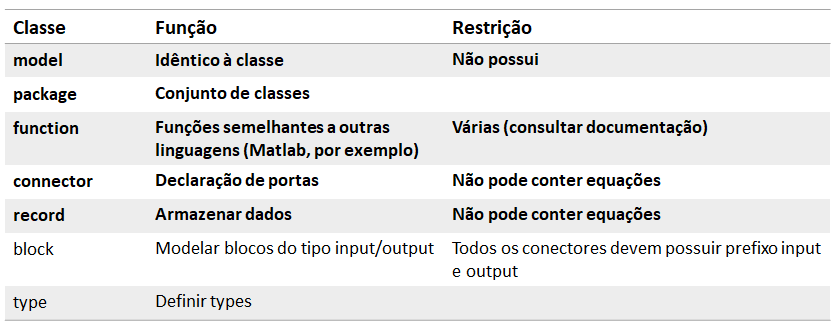

In [1]:
from IPython.display import Image
Image(filename='Figuras/Tabela_classes.png')

# JModelica + Python

* $\textbf{Modelar}$ sistemas usando linguagem orientada à objeto Modelica.
* $\textbf{Simular}$  resolver e otimizar problemas usando as ferramentas de integração.
* $\textbf{Automatizar}$ simulações e otimizações em scripts em Python.
* $\textbf{Visualizar}$  resultados. 


# Exemplo 1: Tanque simples

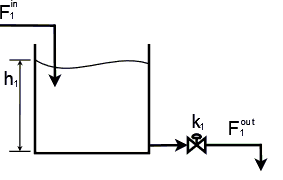

In [56]:
from IPython.display import Image
Image(filename='Figuras/Tank.png')

Equações do modelo
$$ \frac{dh}{dt} = \frac{F_{i}-F_{o}}{A} $$
$$ F_{o} = \sqrt{(2gh)}k $$

In [5]:
%%file modelTank.mo
model Tank 
    constant Real g=Modelica.Constants.g_n;
    parameter Real A=1;
    parameter Real k=0.2;
    parameter Real Fi = 0.6;
    Real Fo;
    Real h;
equation 
    A*der(h) = (Fi - Fo);
    Fo = sqrt(2*g*h)*k;
end Tank;

Overwriting modelTank.mo


# Simulando o modelo em Python

In [6]:
# Importando pacotes
import matplotlib.pyplot as plt
from pymodelica import compile_fmu
from pyfmi import load_fmu
import numpy as np
%matplotlib inline

$\textbf{O arquivo .MO é compilado em FMU}$, que é um arquivo compactado que pode ser importado por outro ambiente para ser executado.
* Arquivo XML contendo todas as variáveis do modelo;
* Todas as equações do modelo em C;
* Outros dados opcionais do modelo;

In [7]:
fmu_Tank = compile_fmu("Tank","modelTank.mo")  # Compila o modelo

A compilação do modelo é necessária $\textbf{apenas uma única vez}$.

In [9]:
model_Tank = load_fmu(fmu_Tank) # Carrega o modelo em FMU

In [10]:
model_Tank.reset() # Reseta-se o modelo sempre que for rodar a simulação de novo.

tempo_final=10;
amostragem=0.1;

# Roda a simulacao

opts = model_Tank.simulate_options()
opts['ncp']= tempo_final/amostragem;
res_Tank = model_Tank.simulate(start_time=0.,final_time=tempo_final,options=opts)

Final Run Statistics: Tank 

 Number of steps                                 : 79
 Number of function evaluations                  : 107
 Number of Jacobian evaluations                  : 3
 Number of function eval. due to Jacobian eval.  : 3
 Number of error test failures                   : 1
 Number of nonlinear iterations                  : 103
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 0.0001

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.0253977110244 seconds.


# Simulação em tempo real

In [11]:
h_treal = []
time = res_Tank['time']
model_Tank.reset() # Resetando o modelo para os valores origitais
model_Tank.initialize() # Inicializando o experimento
opts['CVode_options']['verbosity'] = 50 # Sem output
opts['initialize'] = False # Isso quer dizer que o experimento continua de onde ele parou, sem precisar inicializar o modelo

for i in range(0, int(tempo_final/amostragem)):
    res_Tankr = model_Tank.simulate(start_time=(time[i]),final_time=(time[i+1]),options = opts)
    if i == 0: # Valor da altura quando t = 0
        h_treal.append(res_Tankr['h'][0])
    h_treal.append(res_Tankr['h'][-1])

# Resposta do modelo em Python

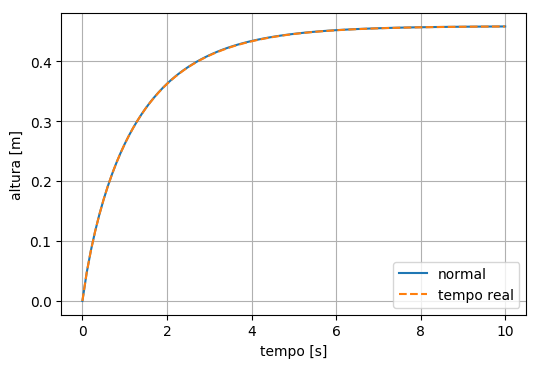

In [12]:
plt.plot(time,res_Tank['h'], '-', time,h_treal, '--')
plt.ylabel('altura [m]')
plt.xlabel('tempo [s]')
plt.legend(['normal', 'tempo real'])
plt.grid()

# Exemplo 2 - Tanque com controle PID

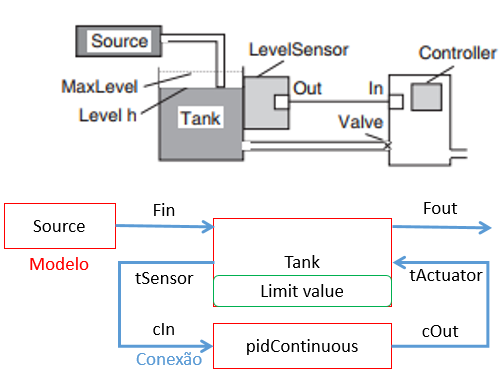

In [61]:
Image(filename='Figuras/TankPID.png') 

Equações do modelo
$$ \frac{dh}{dt} = \frac{F_{i}-F_{o}}{A} $$
$$ F_{o} = \sqrt{(2gh)}k $$

Equação do PID
$$ outCtr = K \Bigg(error + \frac{1}{T}\int error\: \mathrm{dt} + T\frac{d(error)}{dt} \Bigg) $$

Equação do PI
$$ outCtr = K \Bigg(error + \frac{1}{T}\int error\: \mathrm{dt} \Bigg) $$

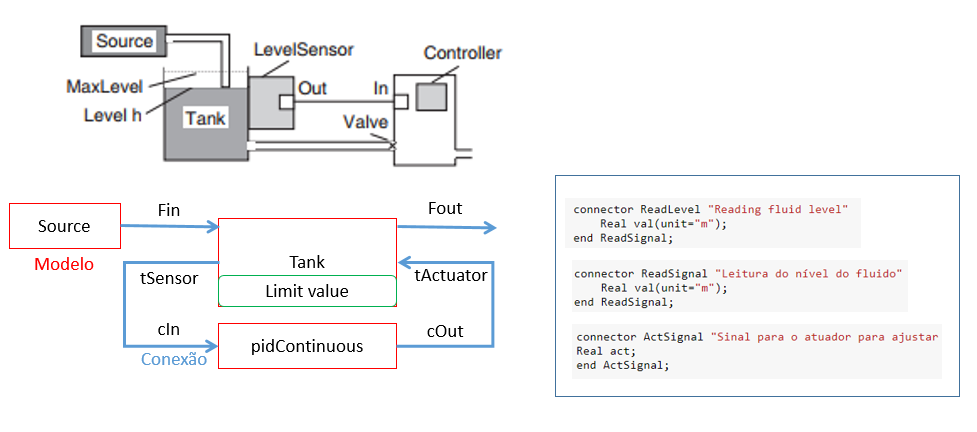

In [62]:
Image(filename='Figuras/TankPID01.png') 

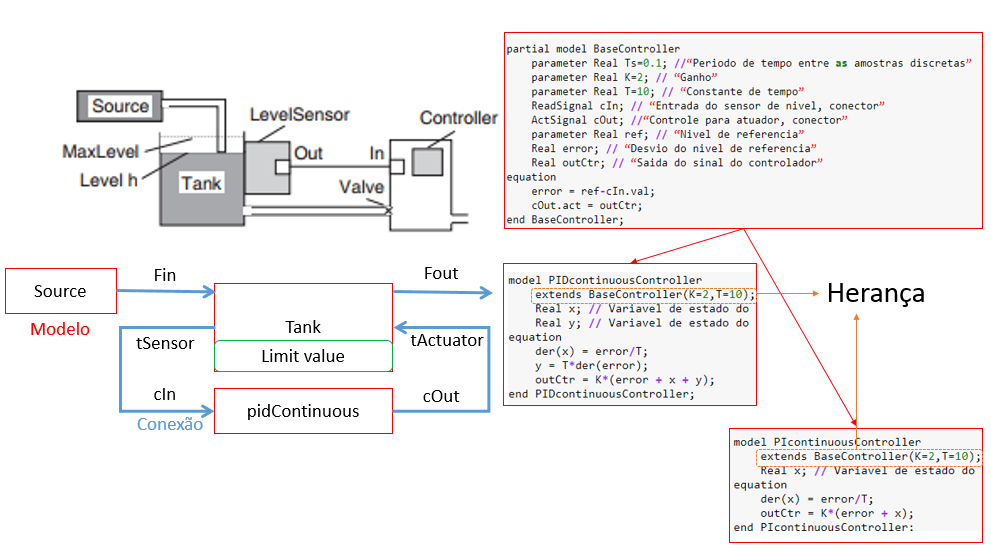

In [63]:
Image(filename='Figuras/TankPID02.png') 

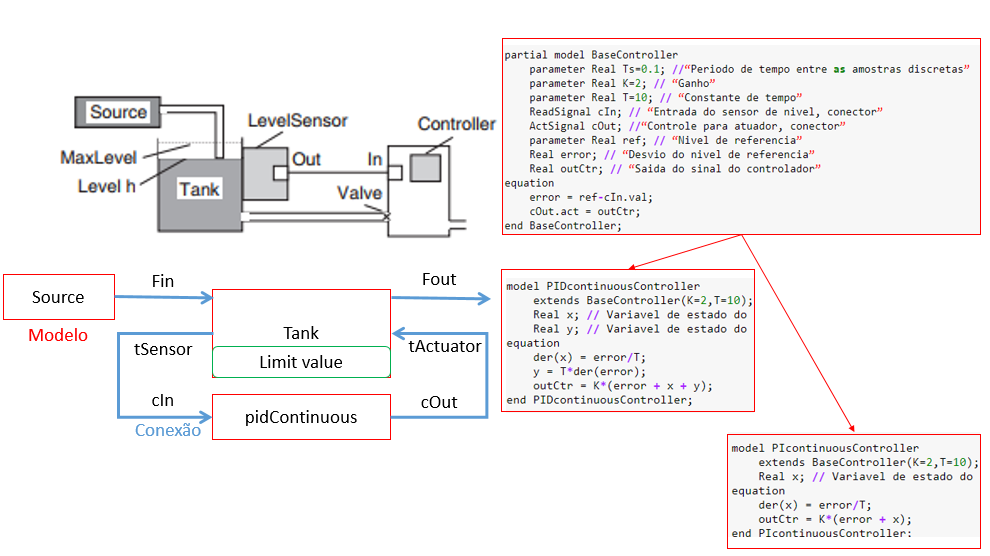

In [64]:
Image(filename='Figuras/TankPID03.png') 

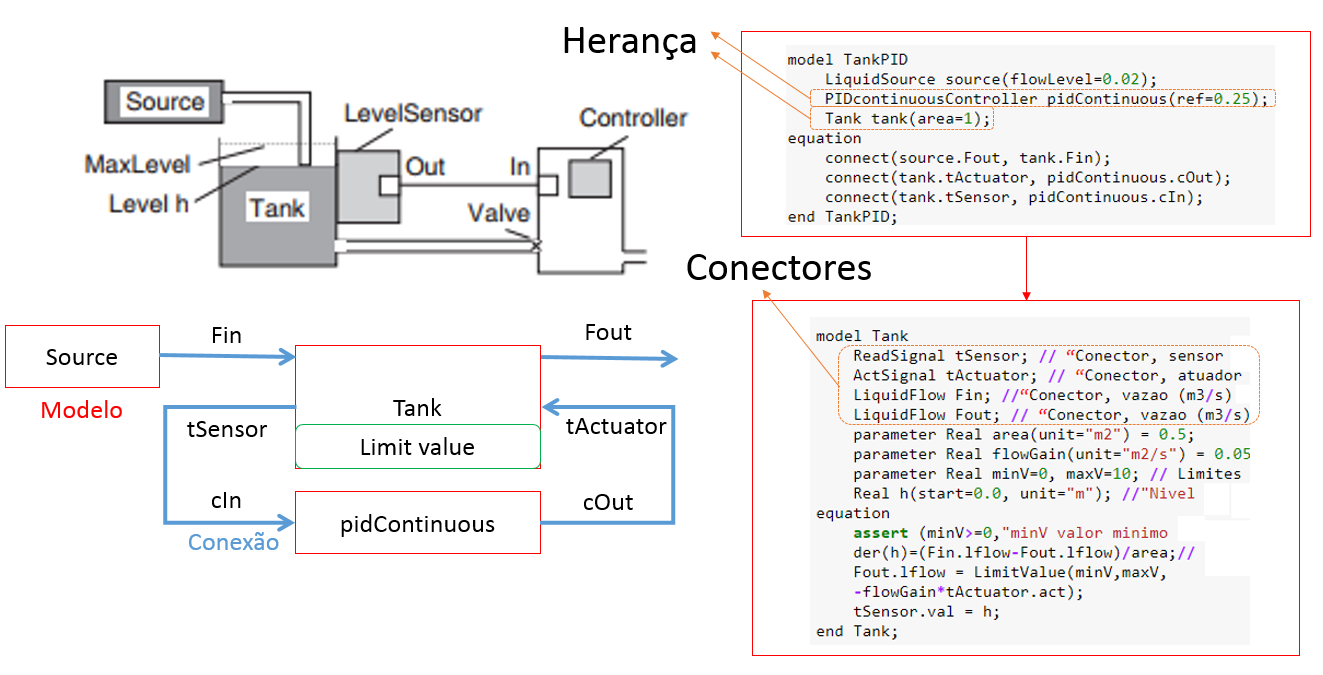

In [65]:
Image(filename='Figuras/TankPID04.png') 

In [2]:
%%file TankPID.mo

connector LiquidFlow "Vazão de líquido nas entradas e saídas"
    Real lflow(unit="m3/s");
end LiquidFlow;

connector ReadSignal "Leitura do nível do fluido"
    Real val(unit="m");
end ReadSignal;

connector ActSignal "Sinal para o atuador para ajustar a posição da válvula"
Real act;
end ActSignal;

function LimitValue
    input Real pMin;
    input Real pMax;
    input Real p;
    output Real pLim;
algorithm
    pLim := if p>pMax then pMax
    else if p<pMin then pMin
    else p;
end LimitValue;

model LiquidSource
    LiquidFlow Fout;
    parameter Real flowLevel = 0.02;
equation
    Fout.lflow = if time>150 then 3*flowLevel else flowLevel;
end LiquidSource;

partial model BaseController
    parameter Real Ts=0.1; //“Periodo de tempo entre as amostras discretas”
    parameter Real K=2; // “Ganho”
    parameter Real T=10; // “Constante de tempo”
    ReadSignal cIn; // “Entrada do sensor de nivel, conector”
    ActSignal cOut; //“Controle para atuador, conector”
    parameter Real ref; // “Nivel de referencia”
    Real error; // “Desvio do nivel de referencia”
    Real outCtr; // “Saida do sinal do controlador”
equation
    error = ref-cIn.val;
    cOut.act = outCtr;
end BaseController;

model PIDcontinuousController
    extends BaseController(K=2,T=10);
    Real x; // Variavel de estado do controlador PID continuo
    Real y; // Variavel de estado do controlador PID continuo
equation
    der(x) = error/T;
    y = T*der(error);
    outCtr = K*(error + x + y);
end PIDcontinuousController;

model PIcontinuousController
    extends BaseController(K=2,T=10);
    Real x; // Variavel de estado do controlador PID continuo
equation
    der(x) = error/T;
    outCtr = K*(error + x);
end PIcontinuousController;

model Tank
    ReadSignal tSensor; // “Conector, sensor lendo o nivel do tanque (m)”
    ActSignal tActuator; // “Conector, atuador controlando entrada da vazao”
    LiquidFlow Fin; //“Conector, vazao (m3/s) atraves da valvula de entrada”
    LiquidFlow Fout; // “Conector, vazao (m3/s) atraves da valvula de saida”
    parameter Real area(unit="m2") = 0.5;
    parameter Real flowGain(unit="m2/s") = 0.05;
    parameter Real minV=0, maxV=10; // Limites para a saida da vazao da valvula
    Real h(start=0.0, unit="m"); //"Nivel do tanque";
equation
    assert (minV>=0,"minV valor minimo da valvula deve ser >= 0");
    der(h)=(Fin.lflow-Fout.lflow)/area;// Mass balance equation
    Fout.lflow = LimitValue(minV,maxV,
    -flowGain*tActuator.act);
    tSensor.val = h;
end Tank;

model TankPID
    LiquidSource source(flowLevel=0.02);
    PIDcontinuousController pidContinuous(ref=0.25);
    Tank tank(area=1);
equation
    connect(source.Fout, tank.Fin);
    connect(tank.tActuator, pidContinuous.cOut);
    connect(tank.tSensor, pidContinuous.cIn);
end TankPID;

model TankPI
    LiquidSource source(flowLevel=0.02);
    PIcontinuousController pidContinuous(ref=0.25);
    Tank tank(area=1);
equation
    connect(source.Fout, tank.Fin);
    connect(tank.tActuator, pidContinuous.cOut);
    connect(tank.tSensor, pidContinuous.cIn);
end TankPI;

Overwriting TankPID.mo


# Simulação do modelo

In [2]:
fmuPI = compile_fmu("TankPI","TankPID.mo")
fmuPID = compile_fmu("TankPID","TankPID.mo")

In [3]:
modelPI= load_fmu(fmuPI)
modelPID= load_fmu(fmuPID)
tempo_final=500;
amostagem=0.1;

# Simulação
opts = modelPI.simulate_options()
opts['ncp']= tempo_final/amostagem;
opts['CVode_options']['verbosity'] = 50 # Sem output
resPI = modelPI.simulate(start_time=0.,final_time=tempo_final,options=opts)
resPID = modelPID.simulate(start_time=0.,final_time=tempo_final,options=opts)

# Resposta do modelo com Bokeh

In [4]:
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import HoverTool

output_notebook()
hover = HoverTool(tooltips=[("(x,y)", "($x, $y)")])
p1 = figure(plot_width=600, plot_height=400,tools=[hover])
p1.line(resPID['time'],resPID['tank.h'],  legend="Simulado PID", line_width=2,color="blue", alpha=0.5)
p1.line(resPID['time'],resPID['pidContinuous.ref'], legend="Set point PID", line_width=2,color="red", alpha=0.5,)
p1.line(resPI['time'],resPI['tank.h'],  line_dash=(4, 4), legend="Simulado PI", line_width=2,color="blue", alpha=0.5)
p1.line(resPI['time'],resPI['pidContinuous.ref'],line_dash=(4, 4), legend="Set point PI", line_width=2,color="red", alpha=0.5,)
p1.legend.click_policy="hide"
p1.yaxis.axis_label = "Altura [m]"
p1.xaxis.axis_label = "Tempo [s]"
tab1 = Panel(child=p1, title="PV")

p2 = figure(plot_width=600, plot_height=400,tools=[hover])
p2.line(resPID['time'],resPID['tank.Fin.lflow'], legend="Entrada PID", line_width=2, color="orange", alpha=0.5)
p2.line(resPID['time'],resPID['tank.Fout.lflow'], legend="Saída PID", line_width=2, color="green", alpha=0.5)
p2.line(resPI['time'],resPI['tank.Fin.lflow'],line_dash=(4, 4), legend="Entrada PI", line_width=2, color="orange", alpha=0.5)
p2.line(resPI['time'],resPI['tank.Fout.lflow'], line_dash=(4, 4), legend="Saída PI", line_width=2, color="green", alpha=0.5)
p2.legend.click_policy="hide"
p2.yaxis.axis_label = "Vazão [m³/s]"
p2.xaxis.axis_label = "Tempo [s]"
tab2 = Panel(child=p2, title="MV")

tabs = Tabs(tabs=[ tab1, tab2 ])
show(tabs)

Loading BokehJS ...

# Exemplo 3 - Estimação de parâmetros

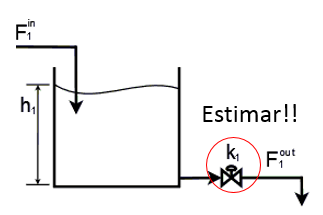

In [66]:
Image(filename='Figuras/Tank_est.png') 

Equações do modelo
$$ \frac{dh}{dt} = \frac{F_{i}-F_{o}}{A} $$
$$ F_{o} = \sqrt{(2gh)}k $$

In [22]:
import numpy as np
import nlopt

par = ['k'] # Parâmetro a ser estimado
lolim=[-100] # Limite inferior
uplim=[100] # Limite superior
guess = [50] # Chute inicial
t_exp= np.hstack(res_Tank['time']); # Valores experimentais
h_exp = np.hstack(res_Tank['h'])+ 0.05*np.mean(res_Tank['h'])*np.random.randn(len(t_exp)); # Valores experimentais + ruído

In [23]:
fmu_Tank = compile_fmu("Tank","modelTank.mo",version ='2.0' , compiler_log_level="error",
compiler_options = {'generate_block_jacobian':True,'generate_ode_jacobian':True})
model_Tank = load_fmu(fmu_Tank)

In [24]:
def funcao_objetivo(estpar, grad): 
    model_Tank.reset()
    model_Tank.set(par,estpar) # Setando o novo valor do parâmetro estimado

    opts = model_Tank.simulate_options() # Opções da simulação
    opts['ncp']=len(t_exp)-1
    opts['CVode_options']['verbosity'] = 50 # Sem output
    
    res_est = model_Tank.simulate(start_time=0,final_time=10,options=opts)
    h_sim = res_est['h']
    
    obj = np.sqrt(sum(np.square(h_exp-h_sim))) # Mínimos quadrados
    
    return obj

In [25]:
optm = nlopt.opt(nlopt.LN_BOBYQA,len(par)) # Seleção do solver
optm.set_lower_bounds(lolim)
optm.set_upper_bounds(uplim)
optm.set_xtol_rel(1e-8)
optm.set_ftol_rel(1e-8)
optm.set_min_objective(lambda estpar,grad: funcao_objetivo(estpar,grad)) # Seleção da função objetivo
x_erro = optm.optimize(guess) # Otimização

In [26]:
x_erro

array([ 0.20017072])

In [27]:
model_Tank.reset()
model_Tank.set(par,x_erro)
opts = model_Tank.simulate_options() # Opções da simulação
opts['CVode_options']['verbosity'] = 50 # Sem output
res_ = model_Tank.simulate(start_time=0,final_time=10,options=opts)

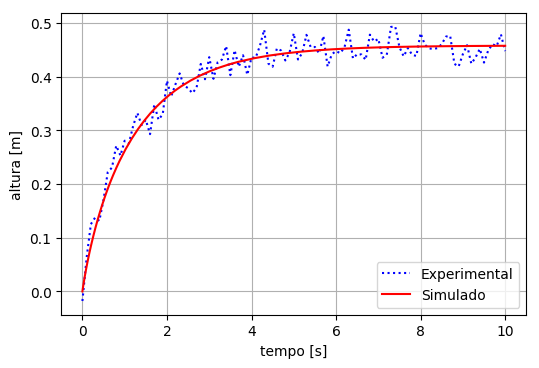

In [28]:
plt.plot(t_exp,h_exp, 'b:', res_['time'],res_['h'],'r-')
plt.legend(['Experimental','Simulado'])
plt.grid()
plt.ylabel('altura [m]')
plt.xlabel('tempo [s]')

# Obtenção do modelo linearizado

In [33]:
[a,b,c,d] = model_Tank.get_state_space_representation(A=True, B=False, C=True, D=False)
A = np.matrix(a.toarray())
A

matrix([[-0.65418972]])

# Análise de sensibilidade

In [32]:
model_Tank.reset()
opts = model_Tank.simulate_options()
opts['sensitivities'] = ['A']
opts['CVode_options']['verbosity'] = 50 # Sem output
res = model_Tank.simulate(start_time=0.,final_time=10,options=opts)

(None,
 <matplotlib.text.Text at 0x18933f10>)

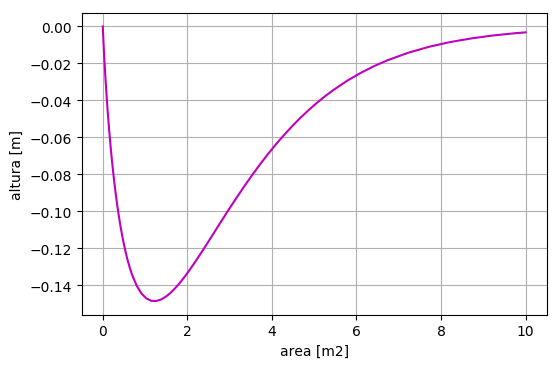

In [29]:
plt.plot(res['time'], res['dh/dA'],'m-')
plt.grid(),plt.ylabel('altura [m]'),plt.xlabel('area [m2]')

# Quer saber mais?

- https://openmodelica.org/useresresources/modelica-courses;
- Principles of Object Oriented Modeling and Simulation with Modelica 3.3- Peter Fritzson;
- Consultar OMNotebook;
- Exemplos da biblioteca do Modelica;
- http://http://www.jmodelica.org/
- https://bokeh.pydata.org/en/latest/
- Introduction to Physical Modeling with Modelica- Michael Tiller

# Obrigada pela atenção!